### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


### Plot kumulatif

Take initial varian plus "L"

In [7]:
df_L = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "L"].copy()
df_L

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6847,2024-08-31,IMELDA,SUMBER JAYA TIMUR,SEPASO BARAT,BENGALON,PEREMPUAN,2004-07-20,MAHASISWA/PELAJAR,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,LP3,L,INDIVIDU,20
6849,2024-08-31,HANIF IHABULLAH IFTIKHAR,JL PENEGAK,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,2005-04-01,MAHASISWA/PELAJAR,"< Rp. 900.000,-",SLTA/SMU,LVE,L,INDIVIDU,19
6850,2024-08-31,FAHREL SAJDAH RIFQIYA LEMAN,JL. MARSMA R ISWAHYUDI,SEPINGGAN RAYA,BALIKPAPAN SELATAN,LAKI-LAKI,1973-03-21,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,LV1,L,INDIVIDU,52
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64


Plot data initial varian plus "L"

In [8]:
df_L_count = df_L[["Tgl. Mohon"]].copy()
df_L_count["count"] = 1.
df_L_count = df_L_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_L_count["cumulative_sum"] = df_L_count["count"].cumsum()
df_L_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-02,5,5
1,2021-01-04,2,7
2,2021-01-05,3,10
3,2021-01-06,4,14
4,2021-01-07,7,21
...,...,...,...
1064,2024-08-27,2,5118
1065,2024-08-28,1,5119
1066,2024-08-29,3,5122
1067,2024-08-30,2,5124


Groub by weekly

In [9]:
df_L_weekly = df_L_count[["Tgl. Mohon"]].copy()
df_L_count["Tgl. Mohon"] = pd.to_datetime(df_L_count["Tgl. Mohon"])

df_L_weekly = (df_L.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_L_weekly["cumulative_sum"] = df_L_weekly["count"].cumsum()
df_L_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,7,7
1,2021-01-11,26,33
2,2021-01-18,10,43
3,2021-01-25,19,62
4,2021-02-01,11,73
...,...,...,...
187,2024-08-05,22,5050
188,2024-08-12,19,5069
189,2024-08-19,25,5094
190,2024-08-26,22,5116


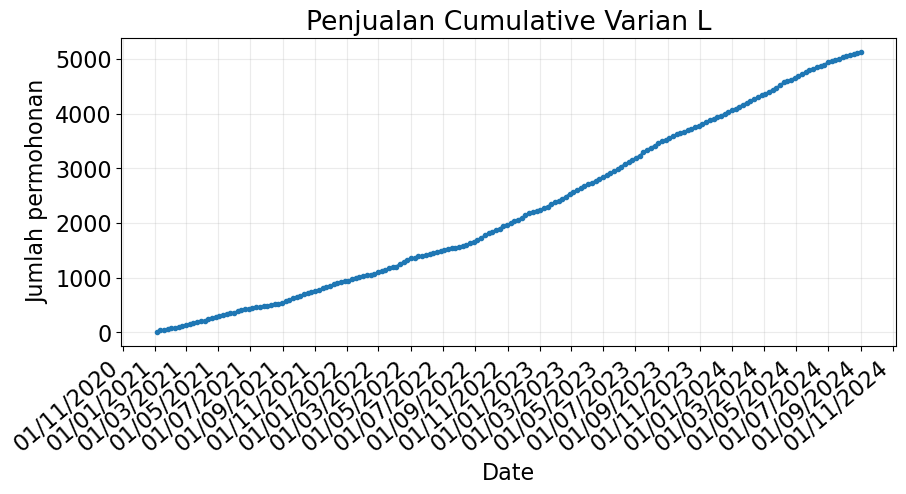

In [10]:
plot_time_series(df_L_weekly["Tgl. Mohon"], df_L_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian L",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [11]:
ADF_result = adfuller(df_L_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 1.0000418373745945
p-value: 0.9942663899610118


first diff (_d_=1)

In [12]:
L_diff_week = np.diff(df_L_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(L_diff_week)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.6830863053482834
p-value: 0.07701108524681861


sec diff (_d_=2)

In [13]:
L_diff2 = np.diff(L_diff_week, n=1)
ADF_result2 = adfuller(L_diff2)
print(f"ADF statistic : {ADF_result2[0]}")
print(f"p-value : {ADF_result2[1]}")

ADF statistic : -11.423106568361865
p-value : 6.797386726765058e-21


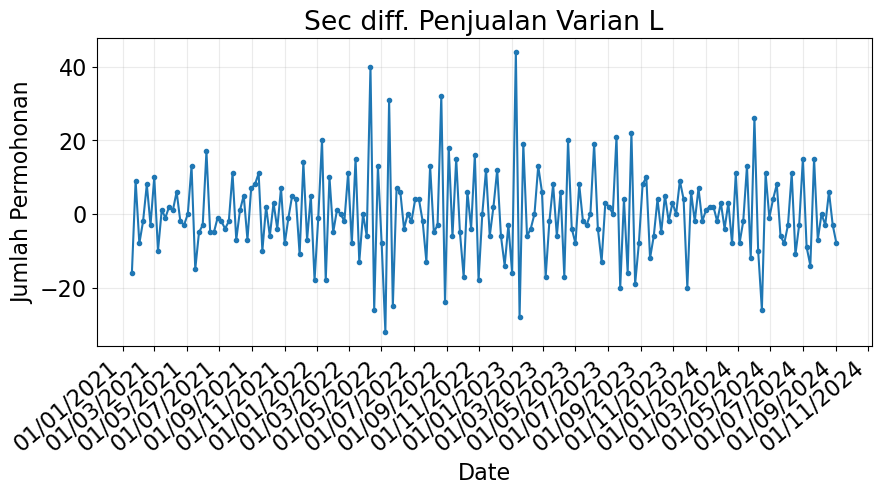

In [14]:
plot_time_series(df_L_weekly["Tgl. Mohon"].iloc[2:], L_diff2, 
                 title="Sec diff. Penjualan Varian L",
                 xlabel="Date", ylabel="Jumlah Permohonan")

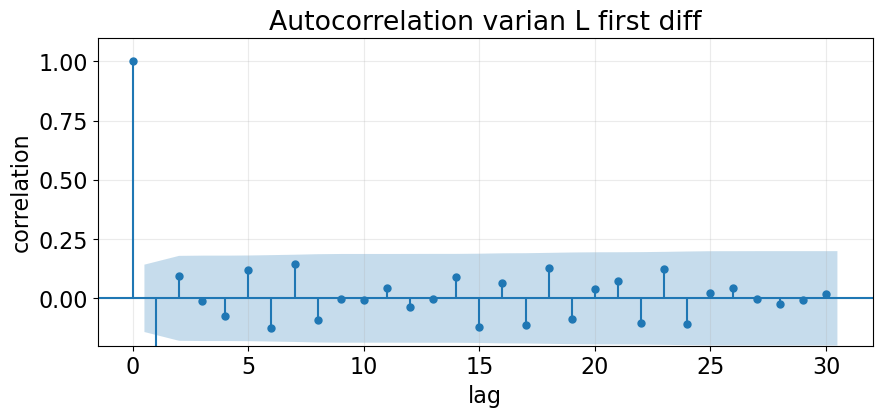

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(L_diff2, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian L first diff")
ax.grid("on")

plt.show(fig)

#### harian

In [16]:
ADF_result = adfuller(df_L_count["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 4.704547484746637
p-value: 1.0


fisrt diff (_d_=1)

In [17]:
L_diff = np.diff(df_L_count["cumulative_sum"], n=1)
ADF_result = adfuller(L_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -3.075095604463298
p-value: 0.028451968450453325


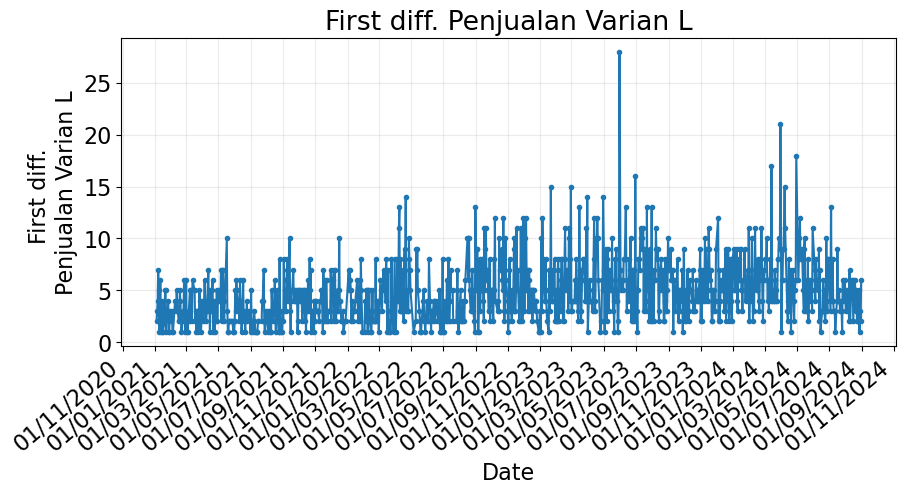

In [18]:
plot_time_series(df_L_count["Tgl. Mohon"].iloc[1:], L_diff, 
                 title="First diff. Penjualan Varian L",
                 xlabel="Date", ylabel="First diff. \nPenjualan Varian L")

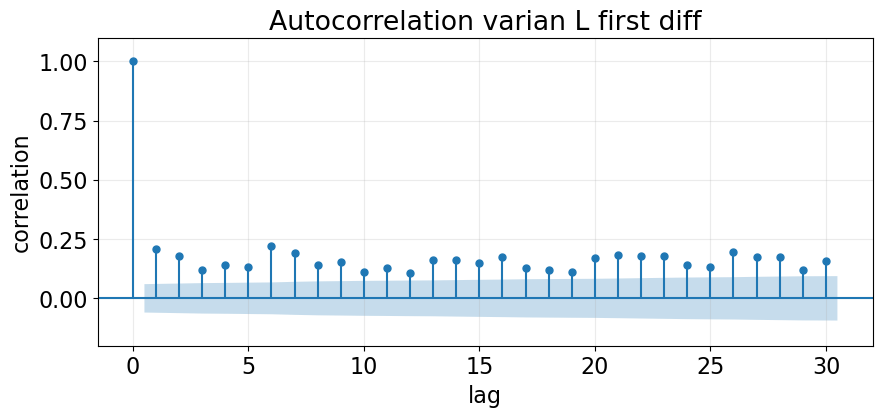

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(L_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian L first diff")
ax.grid("on")

plt.show(fig)

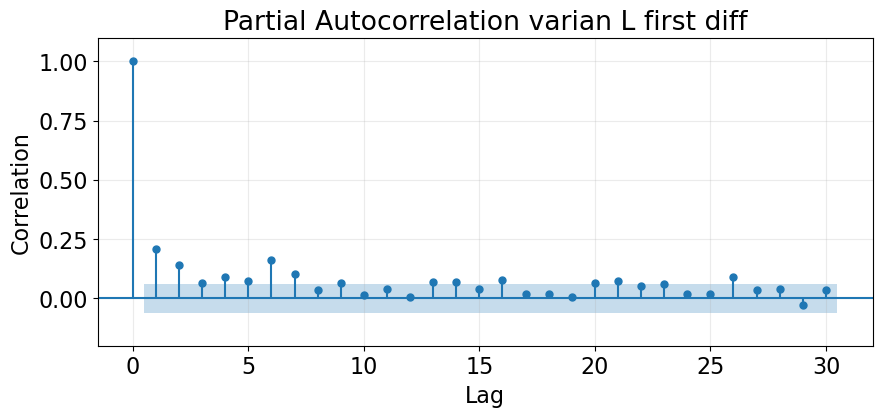

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(L_diff, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian L first diff")
ax.grid("on")

plt.show()

terdapat beberapa lag yang signifikan pada acf dan pacf